In [16]:
#Reloads the lab.py and crystals.py modules to update any changes (after saving)
#If a new method or object is created, autoreload doesn't work and the 
#kernel needs to be closed and halted after saving and making a 'checkpoint'
#in this notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import ipas 
import numpy as np
import dask
from dask_jobqueue import SLURMCluster
from distributed import LocalCluster
from dask.distributed import Client, progress
from dask import delayed
from dask import dataframe as dd
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import pandas as pd
import time
from dask.distributed import as_completed
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import matplotlib.cm as cm
import scipy.stats as st

In [26]:
large = 20; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': large,
          'figure.figsize': (7,7),
          'axes.labelsize': large,
          'axes.titlesize': large,
          'xtick.labelsize': large,
          'ytick.labelsize': large,
          'figure.titlesize': large,
          "font.family": "serif"}
plt.rcParams.update(params)

In [126]:
cluster = SLURMCluster(
    queue='batch',
    walltime='04-23:00:00',
    cores=1,
    memory='20000MiB', #1 GiB = 1,024 MiB
    processes=1)

#cluster.adapt(minimum=3, maximum=20)
cluster.scale(20)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [127]:
client = Client(cluster)

In [181]:
client.retire_workers()

{'tcp://169.226.65.175:44661': {'type': 'Worker',
  'id': 1,
  'host': '169.226.65.175',
  'resources': {},
  'local_directory': '/network/rit/lab/sulialab/share/IPAS_3radii/collection_from_db/worker-8jz976l9',
  'name': 1,
  'nthreads': 1,
  'memory_limit': 20970000000,
  'last_seen': 1588877655.278375,
  'services': {'dashboard': 42717},
  'metrics': {'cpu': 0.0,
   'memory': 1870217216,
   'time': 1588877655.2748966,
   'read_bytes': 1007196.3694648499,
   'write_bytes': 372201.2782444038,
   'num_fds': 61,
   'executing': 0,
   'in_memory': 0,
   'ready': 0,
   'in_flight': 0,
   'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}}},
  'nanny': 'tcp://169.226.65.175:40399'},
 'tcp://169.226.65.97:40999': {'type': 'Worker',
  'id': 15,
  'host': '169.226.65.97',
  'resources': {},
  'local_directory': '/network/rit/lab/sulialab/share/IPAS_3radii/collection_from_db/worker-fsz1nhfs',
  'name': 15,
  'nthreads': 1,
  'memory_limit': 20970000000,
  'last_seen': 1588877655.26992

In [4]:
files = [f for f in glob.glob("../instance_files/createdb_iceagg_flat*")]

In [5]:
%%time 
data = []
for file in files:
    print(file)
    data.append(pd.read_pickle(file, None))
datapd = [pd.DataFrame(i) for i in data]
df = pd.concat(datapd, axis=0, ignore_index=True)
df['agg_r'] = np.power((np.power(df['a'], 2) * df['c']), (1./3.))
df['agg_r'] = df['agg_r'][df.agg_r < 5000]
df['shape'] = df.apply(lambda row: 'prolate' if (row.b - row.c) <= (row.a - row.b) else 'oblate', axis=1)
df['agg_phi'] = df.c/df.a

../instance_files/createdb_iceagg_flat_r500_1000
../instance_files/createdb_iceagg_flat_r90_400
../instance_files/createdb_iceagg_flat_r40_80
../instance_files/createdb_iceagg_flat_r10_30
../instance_files/createdb_iceagg_flat_r1_4
../instance_files/createdb_iceagg_flat_r5_9
CPU times: user 6min 46s, sys: 1min 12s, total: 7min 58s
Wall time: 10min 4s


In [87]:
agg_stats = df['agg_r'].describe().round(2)
agg_stats

count    4872000.00
mean        4012.09
std         8982.76
min            1.73
25%           98.72
50%          629.81
75%         3974.26
max       138997.54
Name: agg_r, dtype: float64

In [373]:
df['agg_r'] = df['agg_r'][df.agg_r < 5000]
stats = df['agg_r'].describe().round(2)
stats
#78% of db

count    4214075.00
mean         823.57
std         1221.32
min            1.47
25%           53.33
50%          254.56
75%          920.76
max         4999.99
Name: agg_r, dtype: float64

In [364]:
agg_stats = df['agg_phi'].describe().round(3)
agg_stats

count    4872000.000
mean           0.322
std            0.237
min            0.005
25%            0.095
50%            0.279
75%            0.538
max            0.977
Name: agg_phi, dtype: float64

# MAIN

In [6]:
ch_dist='gamma'         #anything other than gamma uses the characteristic from the best distribution pdf (lowest SSE)
rand_orient = False      #randomly orient the seed crystal and new crystal: uses first random orientation
save_plots = False  
phi_factor=10
r_factor=2
agg_phi_bins = 20
agg_r_bins = 20
nclusters = 300

In [ ]:
def main():
    
    output = np.empty((agg_phi_bins,agg_r_bins),dtype=object)
    hold_clusters  = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)
    a  = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)
    c = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)

    res, phi_bins = pd.qcut(df.agg_phi, agg_phi_bins, retbins=True)

    for i in range(agg_phi_bins):
        #print('agg phi range: ', phi_bins[i], phi_bins[i+1])
        #return a df that only queries within an aspect ratio bin
        df_phi = df[(df.agg_phi > phi_bins[i]) & (df.agg_phi < phi_bins[i+1])]  
        #to ensure at least 2 crystals within agg since ncrystals=1 not in db
        #now break that aspect ratio bin into 20 equal r bins
        
        res, r_bins = pd.qcut(df_phi.agg_r, agg_r_bins, retbins=True)
        for r in range(agg_r_bins):   #agg r
               
            #print('r = ', r_bins[r], r_bins[r+1])
            df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
            #plt.hist(df_r.mono_phi)
            #plt.xscale('log')
            #plt.show()

            samples = df_r.sample(nclusters)
            for n, agg in enumerate(samples.itertuples()):

                phi_range = np.logspace(np.log(agg.mono_phi/phi_factor)/np.log(10),
                                        np.log(agg.mono_phi*phi_factor)/np.log(10), 20)
                mono_phi = random.choice(phi_range)
                mono_phi = 0.01 if mono_phi < 0.01 else mono_phi
                mono_phi = 70 if mono_phi > 70 else mono_phi

                r_range = np.logspace(np.log(agg.mono_r/r_factor)/np.log(10),\
                                      np.log(agg.mono_r*r_factor)/np.log(10),20)
                mono_r = random.choice(r_range)
                mono_r = 1000 if mono_r>1000 else mono_r
                mono_r = 1 if mono_r<1 else mono_r
                
                a[i,r,n] = (mono_r ** 3 / mono_phi) ** (1. / 3.)
                c[i,r,n] = mono_phi * a[i,r,n]
#               print('phi range', agg.mono_phi, phi_range[0], phi_range[-1], phi_range)
#               print('r range: ', agg.mono_r, r_range[0], r_range[-1], r_range)
                
                hold_clusters[i,r,n] = ipas.Cluster_Calculations(agg)

            #ipas.collect_clusters(a[i,r,:], c[i,r,:], hold_clusters[i,r,:], rand_orient=rand_orient)
            output[i,r] = dask.delayed(ipas.collect_clusters)(a[i,r,:], c[i,r,:],
                                                                 hold_clusters[i,r,:], rand_orient=rand_orient)

    return output, hold_clusters
    

In [ ]:
def compute():
    agg_as = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    agg_bs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    rzs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    phi2Ds = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    cplxs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    dds = np.empty((agg_phi_bins, agg_r_bins, nclusters))

    gather = client.compute([*output.tolist()]) 
    gather = client.gather(gather)
    gather = np.array(gather)
    print(np.shape(gather))
    agg_as = gather[:,:,0,:]
    agg_bs = gather[:,:,1,:]
    agg_cs = gather[:,:,2,:]
    phi2Ds = gather[:,:,3,:]
    cplxs = gather[:,:,4,:] 
    dds = gather[:,:,5,:]

    print('DONE!')
    return agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds

In [ ]:
if __name__ == '__main__':
    
    output, hold_clusters = main()
    agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds= compute()
    results = {'agg_as': agg_as, 'agg_bs':agg_bs, 'agg_cs':agg_cs, 'phi2Ds':phi2Ds, \
               'cplxs':cplxs, 'dds':dds}


In [ ]:
filename = '../instance_files/pulled_clusters_iceagg_flat'
filehandler = open(filename, 'wb')
pickle.dump(hold_clusters, filehandler)
filehandler.close()
print('finished!')

filename = '../instance_files/instance_db_iceagg_flat'
filehandler = open(filename, 'wb')
pickle.dump(results, filehandler)
filehandler.close()
print('finished!')

## LOAD DATA

In [7]:
f = open('../instance_files/instance_db_iceagg_flat', 'rb')
results = pickle.load(f)
agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds= \
                results['agg_as'], results['agg_bs'], results['agg_cs'], results['phi2Ds'], results['cplxs'], results['dds']
f.close()

f = open('../instance_files/pulled_clusters_iceagg_flat', 'rb')
pulled_clus = pickle.load(f)
f.close()

In [177]:
pos = np.sum(dds >= 0)
neg = np.sum(dds <= 0)
pos/neg

0.588162892574015

In [9]:
def query_ncrystals(df_phi, r_bins):
    avg_ncrystals = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_ncrystals.append(df_r.ncrystals.mean())
    return avg_ncrystals


In [10]:
def avg_cplx(df_phi, r_bins):
    avg_cplx = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_cplx.append(np.mean(df_r.cplx))
        
    return avg_cplx


In [11]:
def oblate_prolate(df_phi, r_bins):
    oblates = []
    prolates = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) & (df_phi.ncrystals > 2)]
        oblate = df_r['shape'][df_r['shape'] == 'oblate'].count()
        prolate = df_r['shape'][df_r['shape'] == 'prolate'].count()
        oblates.append(oblate)
        prolates.append(prolate)
    return oblates, prolates

In [12]:
def plate_columns_agg(df_phi, r_bins):
    agg_mono_phi = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) & (df_phi.ncrystals > 2)]
        agg_mono_plates = df_r['mono_phi'][df_r['mono_phi'] < 1.0].count()
        agg_mono_col = df_r['mono_phi'][df_r['mono_phi'] > 1.0].count()
        agg_mono_phi.append(agg_mono_plates - agg_mono_col)
    return agg_mono_phi


In [13]:
def average_radius(df_phi, r_bins):
    avg_radius = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_radius.append(np.mean(df_r.mono_r))
    return avg_radius

In [14]:
#RAND
res, phi_bins = pd.qcut(df.agg_phi, 20, retbins=True)
#print(phi_bins)
phi_bin_labs = []
avg_ncrystals=np.empty((len(phi_bins)-1,len(phi_bins)-1))
avg_cplxs=np.empty((len(phi_bins)-1,len(phi_bins)-1))
all_r_bins= np.empty((len(phi_bins),len(phi_bins)))
oblates= np.empty((len(phi_bins)-1,len(phi_bins)-1))
prolates= np.empty((len(phi_bins)-1,len(phi_bins)-1))
agg_mono_phi = np.empty((len(phi_bins)-1,len(phi_bins)-1))
avg_radius = np.empty((len(phi_bins)-1,len(phi_bins)-1))

for i in range(agg_phi_bins):
    print('i = ', i)
    phi_bin_labs.append('[%.3f-%.3f]' %(phi_bins[i],phi_bins[i+1]))
    #return a df that only queries within an aspect ratio bin
    df_phi = df[(df.agg_phi > phi_bins[i]) & (df.agg_phi < phi_bins[i+1])]
    #now break that aspect ratio bin into 20 equal r bins
    res, r_bins = pd.qcut(df_phi.agg_r, 20, retbins=True)
    all_r_bins[i,:] = r_bins
    
    #now use those r bins from the output of queried r and phi to find # of monomers per bin
    avg_ncrystals[i,:] = query_ncrystals(df_phi, r_bins)
    avg_cplxs[i,:] = avg_cplx(df_phi, r_bins)
    oblates[i,:], prolates[i,:] = oblate_prolate(df_phi, r_bins)
    agg_mono_phi[i,:] = plate_columns_agg(df_phi, r_bins)
    avg_radius[i,:] = average_radius(df_phi, r_bins)
    

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


Text(0.5, 1.0, 'Random Orientation')

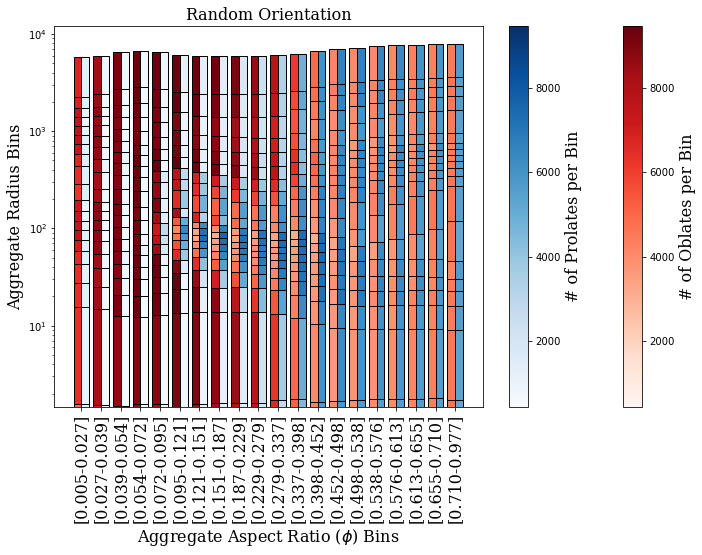

In [146]:
fig, ax = plt.subplots(figsize=(12,7))
cmap_ob = plt.cm.Reds
cmap_pro = plt.cm.Blues
variable1 = oblates
variable2 = prolates
norm1 = matplotlib.colors.Normalize(vmin=min(np.amin(variable1),np.amin(variable2)), vmax=max(np.amax(variable2), np.amax(variable1)))
norm2 = matplotlib.colors.Normalize(vmin=min(np.amin(variable2),np.amin(variable1)), vmax=max(np.amax(variable2), np.amax(variable1)))
#norm = matplotlib.colors.Normalize(vmin=np.amin(shape), vmax=np.amax(shape))

width=1.2
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):  
 
        if r != 0:
            plt.bar(i*3, all_r_bins[i,r], width=width, bottom= all_r_bins[i,r-1], color=cmap_ob(norm1(variable1[i,r])), edgecolor='k')
        else:
            plt.bar(i*3, all_r_bins[i,r], width=width, color=cmap_ob(norm1(variable1[i,r])), edgecolor='k')

for i in range(agg_phi_bins): 
    for r in range(agg_r_bins):
        if r != 0:
            plt.bar((i*3)+width, all_r_bins[i,r],width=width, bottom= all_r_bins[i,r-1], color=cmap_pro(norm2(variable2[i,r])), edgecolor='k')
        else:
            plt.bar((i*3)+width, all_r_bins[i,r],width=width, color=cmap_pro(norm2(variable2[i,r])), edgecolor='k')

            
plt.yscale('log')
plt.xticks((np.arange(20)*3)+width/2, phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",fontsize=16,family='serif')  
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax)

# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# cax2 = divider.append_axes("right", size="5%", pad=1.)


cb1 = cm.ScalarMappable(norm=norm1, cmap=cmap_ob)
cbar1 = plt.colorbar(cb1, format='%d')
cb2 = cm.ScalarMappable(norm=norm2, cmap=cmap_pro)
cbar2 = plt.colorbar(cb2,format='%d')

cbar1.ax.set_ylabel('# of Oblates per Bin', fontsize=16, family='serif')
cbar2.ax.set_ylabel('# of Prolates per Bin', fontsize=16, family='serif')
plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
#plt.title('Random Orientation',fontsize=16, family='serif')
#plt.tight_layout()
#plt.savefig('bins_flat_shape.eps')


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


Text(0.5, 1.0, 'Random Orientation')

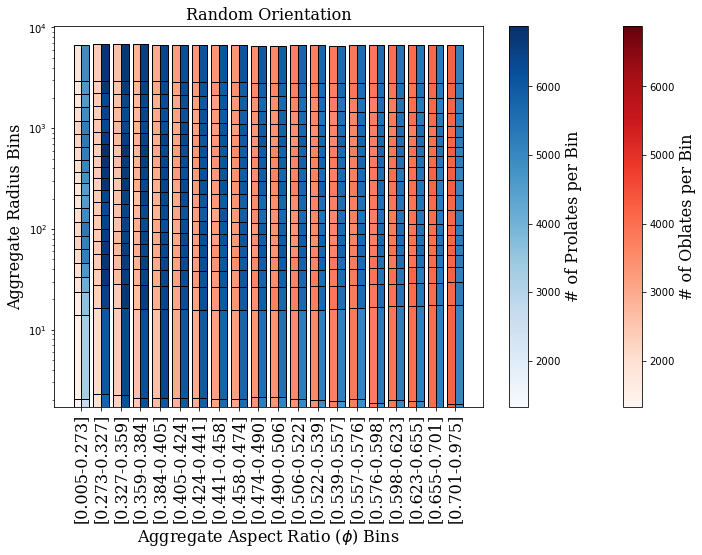

In [23]:
fig, ax = plt.subplots(figsize=(12,7))
cmap_ob = plt.cm.Reds
cmap_pro = plt.cm.Blues
variable1 = oblates
variable2 = prolates
norm1 = matplotlib.colors.Normalize(vmin=min(np.amin(variable1),np.amin(variable2)), vmax=max(np.amax(variable2), np.amax(variable1)))
norm2 = matplotlib.colors.Normalize(vmin=min(np.amin(variable2),np.amin(variable1)), vmax=max(np.amax(variable2), np.amax(variable1)))
#norm = matplotlib.colors.Normalize(vmin=np.amin(shape), vmax=np.amax(shape))

width=1.2
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):  
 
        if r != 0:
            plt.bar(i*3, all_r_bins[i,r], width=width, bottom= all_r_bins[i,r-1], color=cmap_ob(norm1(variable1[i,r])), edgecolor='k')
        else:
            plt.bar(i*3, all_r_bins[i,r], width=width, color=cmap_ob(norm1(variable1[i,r])), edgecolor='k')

for i in range(agg_phi_bins): 
    for r in range(agg_r_bins):
        if r != 0:
            plt.bar((i*3)+width, all_r_bins[i,r],width=width, bottom= all_r_bins[i,r-1], color=cmap_pro(norm2(variable2[i,r])), edgecolor='k')
        else:
            plt.bar((i*3)+width, all_r_bins[i,r],width=width, color=cmap_pro(norm2(variable2[i,r])), edgecolor='k')

            
plt.yscale('log')
plt.xticks((np.arange(20)*3)+width/2, phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",fontsize=16,family='serif')  
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax)

# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# cax2 = divider.append_axes("right", size="5%", pad=1.)

cb1 = cm.ScalarMappable(norm=norm1, cmap=cmap_ob)
cbar1 = plt.colorbar(cb1, format='%d')
cb2 = cm.ScalarMappable(norm=norm2, cmap=cmap_pro)
cbar2 = plt.colorbar(cb2,format='%d')

cbar1.ax.set_ylabel('# of Oblates per Bin', fontsize=16, family='serif')
cbar2.ax.set_ylabel('# of Prolates per Bin', fontsize=16, family='serif')
#plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
plt.title('Random Orientation',fontsize=16, family='serif')
#plt.tight_layout()
#plt.savefig('bins_rand_meanmono_r_5000rad_logy.pdf')


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


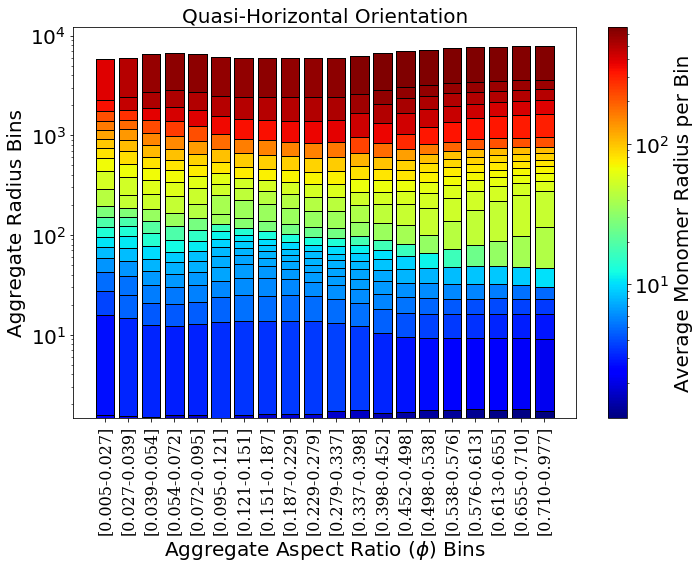

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.cm.jet
variable = avg_radius
norm = matplotlib.colors.LogNorm(vmin=np.amin(variable), vmax=np.amax(variable))

#norm = matplotlib.colors.Normalize(vmin=np.amin(shape), vmax=np.amax(shape))
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):

        if r != 0:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
        else:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')
                
    
plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins")
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins")  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(cb)
cbar.ax.set_ylabel('Average Monomer Radius per Bin')
plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation')
plt.tight_layout()
plt.savefig('../plots/bins_flat_meanmono_r.png')


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


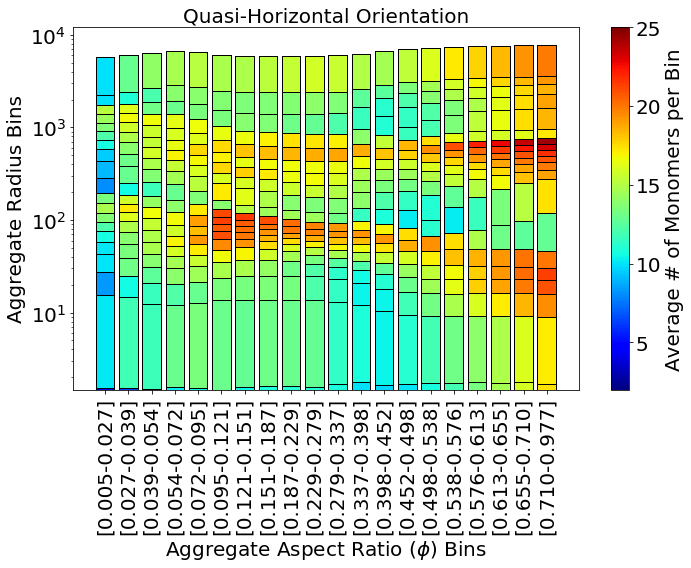

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.cm.jet
variable = avg_ncrystals
norm = matplotlib.colors.Normalize(vmin=2, vmax=25)

for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r):

        if r != 0:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
        else:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')
    
plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
plt.ylabel("Aggregate Radius Bins")
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins")  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(cb, format='%d')
cbar.ax.set_ylabel('Average # of Monomers per Bin')
plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation',fontsize=16, family='serif')
plt.tight_layout()
plt.savefig('../plots/bins_flat_meanmono_ncrys.png')


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


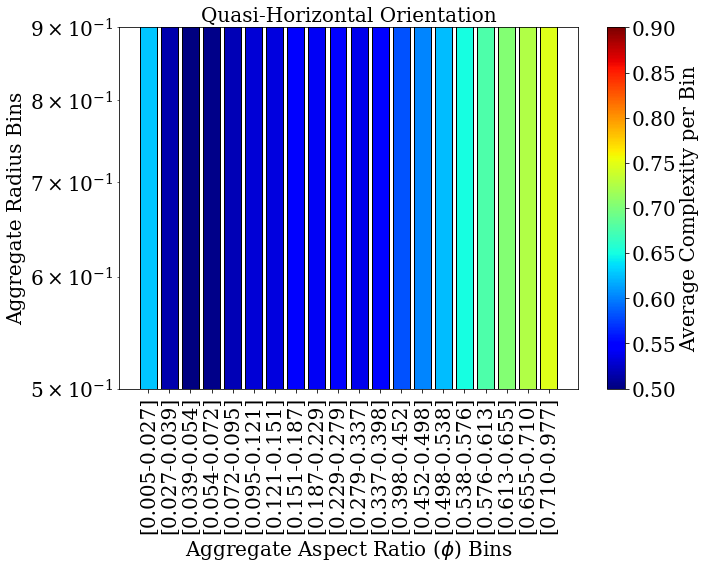

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.cm.jet
variable = avg_cplxs
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=0.9)

for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):
        if r != 0:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
        else:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')
                
plt.ylim(0.5, 0.9)    
plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
plt.ylabel("Aggregate Radius Bins")
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins")  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(cb, format='%.2f')
cbar.ax.set_ylabel('Average Complexity per Bin')
plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation',fontsize=16, family='serif')
plt.tight_layout()
plt.savefig('../plots/bins_flat_meancplx.png')


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


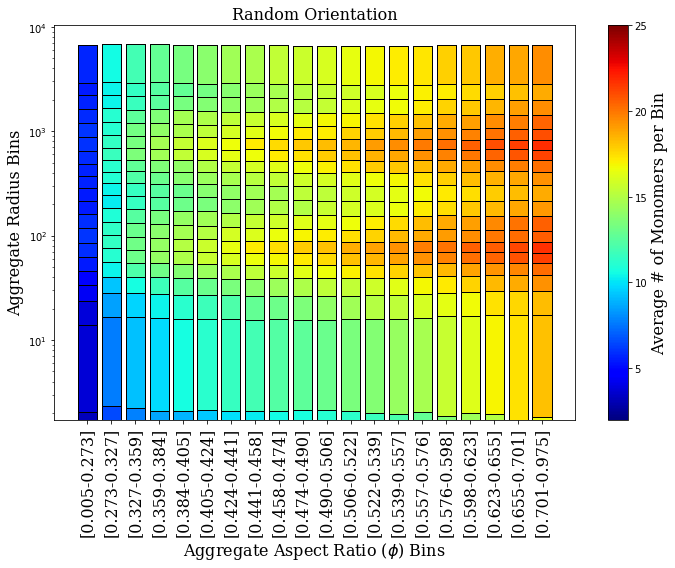

In [64]:
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.cm.jet
variable = avg_ncrystals
norm = matplotlib.colors.Normalize(vmin=2, vmax=25)

for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):

        if r != 0:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
        else:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')
                
    
plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",fontsize=16,family='serif')  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(cb, format='%d')
cbar.ax.set_ylabel('Average # of Monomers per Bin', fontsize=16, family='serif')
#plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
plt.title('Random Orientation',fontsize=16, family='serif')
plt.tight_layout()
#plt.savefig('bins_rand_meanmono_ncrys.eps')


# Lookup tables - iceagg from db

In [48]:
def calculate_error(data, numaspectratios, ch):
    mean = np.mean(data)

    std = np.std(data)
    shape = (mean/std)**2
    scale = (std**2)/mean
    shapech = mean/(numaspectratios*ch)

    pos_error = mean + std
    neg_error = mean - std

    min_data = min(data)
    max_data = max(data)

    return(pos_error, neg_error, min_data, max_data, mean)   

def mode_of_hist(data):
    bins = (np.max(data) - np.min(data))/0.01
    n, bins, patches = plt.hist(data, bins=int(bins), normed=True,
                                color='navy',range=(min(data), max(data)))
    mode = bins[np.where(n == np.max(n))]

    return mode[0]


def fit_distribution(data, normed = True, facecolor='navy', alpha=1.0, axes=None, **kwargs):

 
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    data[np.isinf(data)] = min(data)
    data[np.isnan(data)] = min(data)
    data= data[(data<np.quantile(data, .98)) & (data>np.quantile(data, .01))]
    
    # Get histogram of original data
    y, x = np.histogram(data, density=True)
    params = st.gamma.fit(data)
    arg = params[:-2]       

    fit_alpha, fit_loc, fit_beta=st.gamma.fit(data)
    pdf = st.gamma.pdf(x, a=fit_alpha, loc=fit_loc, scale=fit_beta)
    indmax = np.argmax(pdf)  #FIRST index where the highest prob occurs
    gammach_var = x[indmax] #characteristic of the distribution
    if axes is not None:
        n, bins, patches = plt.hist(data, bins=70, normed=True,
                                color='navy',**kwargs)

        ax = plt.plot(x, pdf, lw=5, color='darkorange')
        plt.ylim(0,max(n))
        plt.show()

    return gammach_var

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


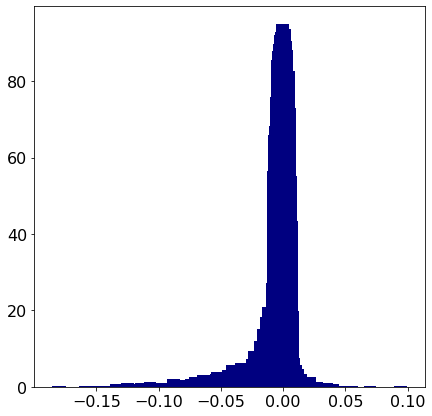

In [49]:
#find characteristic of gamma distribution
numaspectratios=len(agg_as[:,0,0])
numrs=len(agg_bs[0,:,0])
agg_cs_ch = np.empty((numaspectratios, numrs), dtype=np.float64) #major
agg_as_ch = np.empty((numaspectratios, numrs), dtype=np.float64) #minor
agg_as_mean = np.empty((numaspectratios, numrs), dtype=np.float64)
dds_mode = np.empty((numaspectratios, numrs), dtype=np.float64)
# fig = plt.figure(figsize=(5,7))
# ax = plt.subplot(131)

for i in range(numaspectratios):
    for r in range(numrs):
        #print(i,r)
        for c, data in enumerate([agg_cs, agg_as, dds]):
            if c == 0:
                agg_cs_ch[i,r] = fit_distribution(data[i,r,:])
            if c == 1:
                agg_as_ch[i,r] = fit_distribution(data[i,r,:])
                _,_,_,_,agg_as_mean[i,r] = calculate_error(data[i,r,:], numaspectratios, agg_as_ch[i,r])
            if c == 2:
                #dds_mode[i,r] = fit_distribution(dds[i,r,:], axes=ax)
                dds_mode[i,r] = mode_of_hist(dds[i,r,:])
        

In [50]:
#write to file for output as array:
with open("../lookup_tables/ice_agg/newformat_minorax_ellipsoid_flat_ch_binedges.dat","w") as file1:
    with open("../lookup_tables/ice_agg/newformat_majorax_ellipsoid_flat_ch_binedges.dat","w") as file2:
        with open("../lookup_tables/ice_agg/newformat_majorax_ellipsoid_flat_mean_binedges.dat","w") as file3:
            with open("../lookup_tables/ice_agg/newformat_dd_flat_mode_binedges.dat","w") as file4:

                    file1.write('Ice-Agg collection for the flat orientation. \n'\
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')

                    file2.write('Ice-Agg collection for the flat orientation. \n'
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')

                    file3.write('Ice-Agg collection for the flat orientation. \n'
                                'Mean value taken from the average across 300 aggregates. \n'\
                                'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')
                    
                    file4.write('Ice-Agg collection for the flat orientation. \n'
                                'Mode from 300 aggregates. \n' \
                                'Characteristic value taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')


                    for i in range(agg_phi_bins):
                        for r in range(agg_r_bins):
                            listmonophi = [n.monophi for n in pulled_clus[i,r,:]]
                            maxmonophi = max(listmonophi)
                            minmonophi = min(listmonophi)
                            listmonor = [n.monor for n in pulled_clus[i,r,:]]
                            maxmonor = max(listmonor)
                            minmonor = min(listmonor)
                            listaggphi = [n.c/n.a for n in pulled_clus[i,r,:]]
                            maxaggphi = max(listaggphi)
                            minaggphi = min(listaggphi)
                            listaggr = [n.r for n in pulled_clus[i,r,:]]
                            maxaggr = max(listaggr)
                            minaggr = min(listaggr)
                            #print(i,r)
                            file1.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1],  minmonophi, maxmonophi, minmonor, maxmonor, agg_cs_ch[i,r]))
                            file2.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1],  minmonophi, maxmonophi, minmonor, maxmonor, agg_as_ch[i,r]))
                            file3.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1],  minmonophi, maxmonophi, minmonor, maxmonor, agg_as_mean[i,r]))
                            file4.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1],  minmonophi, maxmonophi, minmonor, maxmonor, dds_mode[i,r]))
                                    
file1.close()
file2.close() 
file3.close()
file4.close()

In [180]:
for i in range(agg_phi_bins):
    for r in range(agg_r_bins):
        listmonophi = [n.monophi for n in pulled_clus[i,r,:]]
        maxmonophi = max(listmonophi)
        minmonophi = min(listmonophi)
        listmonor = [n.monor for n in pulled_clus[i,r,:]]
        maxmonor = max(listmonor)
        minmonor = min(listmonor)
        print(minmonophi, maxmonophi, minmonor, maxmonor)

0.01 100.0 1 9
0.01 100.0 1 10
0.01 100.0 1 20
0.01 100.0 2 30
0.01 100.0 2 40
0.01 100.0 3 50
0.01 100.0 4 60
0.01 100.0 5 80
0.01 100.0 5 100
0.01 100.0 7 100
0.01 100.00000000000001 10 200
0.01 100.00000000000001 20 300
0.01 100.00000000000001 20 400
0.01 100.00000000000001 30 500
0.01 100.00000000000001 30 600
0.009999999999999998 100.00000000000001 40 800
0.009999999999999998 100.0 50 1000
0.009999999999999998 100.0 60 1000
0.009999999999999998 100.0 80 1000
0.009999999999999998 100.00000000000001 200 1000
0.01 100.0 1 9
0.01 100.0 1 10
0.01 100.0 1 20
0.01 100.0 2 30
0.01 100.0 2 40
0.01 100.0 3 60
0.01 100.0 4 70
0.01 100.0 5 90
0.01 100.0 5 100
0.01 100.0 6 100
0.01 100.0 9 200
0.01 100.00000000000001 20 300
0.01 100.00000000000001 20 300
0.01 100.00000000000001 30 500
0.01 100.00000000000001 40 600
0.009999999999999998 100.00000000000001 40 800
0.009999999999999998 100.00000000000001 50 1000
0.009999999999999998 100.0 60 1000
0.009999999999999998 100.0 80 1000
0.00999999999999

In [51]:
#write to file for output as array:
with open("../lookup_tables/ice_agg/newformat_minorax_ellipsoid_flat_ch.dat","w") as file1:
    with open("../lookup_tables/ice_agg/newformat_majorax_ellipsoid_flat_ch.dat","w") as file2:
        with open("../lookup_tables/ice_agg/newformat_majorax_ellipsoid_flat_mean.dat","w") as file3:
            with open("../lookup_tables/ice_agg/newformat_dd_flat_mode.dat","w") as file4:

                    file1.write('Ice-Agg collection for the flat orientation. \n'\
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')

                    file2.write('Ice-Agg collection for the flat orientation. \n'
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')

                    file3.write('Ice-Agg collection for the flat orientation. \n'
                                'Mean value taken from the average across 300 aggregates. \n'\
                                'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')
                    
                    file4.write('Ice-Agg collection for the flat orientation. \n'
                                'Volume ratio of agg subtracted from volume ratio of new agg (Vagg/Vellipse)\n'\
                                'Mode from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')


                    for i in range(agg_phi_bins):
                        for r in range(agg_r_bins):
                            listmonophi = [n.monophi for n in pulled_clus[i,r,:]]
                            maxmonophi = max(listmonophi)
                            minmonophi = min(listmonophi)
                            listmonor = [n.monor for n in pulled_clus[i,r,:]]
                            maxmonor = max(listmonor)
                            minmonor = min(listmonor)
                            listaggphi = [n.c/n.a for n in pulled_clus[i,r,:]]
                            maxaggphi = max(listaggphi)
                            minaggphi = min(listaggphi)
                            listaggr = [n.r for n in pulled_clus[i,r,:]]
                            maxaggr = max(listaggr)
                            minaggr = min(listaggr)
                            #print(i,r)
                            file1.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr,  minmonophi, maxmonophi, minmonor, maxmonor, agg_cs_ch[i,r]))
                            file2.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr,  minmonophi, maxmonophi, minmonor, maxmonor, agg_as_ch[i,r]))
                            file3.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr,  minmonophi, maxmonophi, minmonor, maxmonor, agg_as_mean[i,r]))
                            file4.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr,  minmonophi, maxmonophi, minmonor, maxmonor, dds_mode[i,r]))
                                    
file1.close()
file2.close() 
file3.close()
file4.close()

In [55]:
#write to file for output as array:
with open("../lookup_tables/ice_agg/newformat_minorax_ellipsoid_rand_ch.dat","w") as file1:
    with open("../lookup_tables/ice_agg/newformat_majorax_ellipsoid_rand_ch.dat","w") as file2:
        with open("../lookup_tables/ice_agg/newformat_majorax_ellipsoid_rand_mean.dat","w") as file3:
            with open("../lookup_tables/ice_agg/newformat_dd_rand_mode.dat","w") as file4:

                    file1.write('Ice-Agg collection for the random orientation. \n'\
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')

                    file2.write('Ice-Agg collection for the random orientation. \n'
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')

                    file3.write('Ice-Agg collection for the random orientation. \n'
                                'Mean value taken from the average across 300 aggregates. \n'\
                                'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')
                    
                    file4.write('Ice-Agg collection for the random orientation. \n'
                                'Volume ratio of agg subtracted from volume ratio of new agg (Vagg/Vellipse)\n'\
                                'Mode from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')


                    for i in range(agg_phi_bins):
                        for r in range(agg_r_bins):
                            listmonophi = [n.monophi for n in pulled_clus[i,r,:]]
                            maxmonophi = max(listmonophi)
                            minmonophi = min(listmonophi)
                            listmonor = [n.monor for n in pulled_clus[i,r,:]]
                            maxmonor = max(listmonor)
                            minmonor = min(listmonor)
                            listaggphi = [n.c/n.a for n in pulled_clus[i,r,:]]
                            maxaggphi = max(listaggphi)
                            minaggphi = min(listaggphi)
                            listaggr = [n.r for n in pulled_clus[i,r,:]]
                            maxaggr = max(listaggr)
                            minaggr = min(listaggr)
                            #print(i,r)
                            file1.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr,  minmonophi, maxmonophi, minmonor, maxmonor, agg_cs_ch[i,r]))
                            file2.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr,  minmonophi, maxmonophi, minmonor, maxmonor, agg_as_ch[i,r]))
                            file3.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr,  minmonophi, maxmonophi, minmonor, maxmonor, agg_as_mean[i,r]))
                            file4.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr,  minmonophi, maxmonophi, minmonor, maxmonor, dds_mode[i,r]))
                                    
file1.close()
file2.close() 
file3.close()
file4.close()

In [56]:
#write to file for output as array:
with open("../lookup_tables/ice_agg/newformat_minorax_ellipsoid_rand_ch_binedges.dat","w") as file1:
    with open("../lookup_tables/ice_agg/newformat_majorax_ellipsoid_rand_ch_binedges.dat","w") as file2:
        with open("../lookup_tables/ice_agg/newformat_majorax_ellipsoid_rand_mean_binedges.dat","w") as file3:
            with open("../lookup_tables/ice_agg/newformat_dd_rand_mode_binedges.dat","w") as file4:

                    file1.write('Ice-Agg collection for the random orientation. \n'\
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')

                    file2.write('Ice-Agg collection for the random orientation. \n'
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')

                    file3.write('Ice-Agg collection for the random orientation. \n'
                                'Mean value taken from the average across 300 aggregates. \n'\
                                'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')
                    
                    file4.write('Ice-Agg collection for the random orientation. \n'
                                'Volume ratio of agg subtracted from volume ratio of new agg (Vagg/Vellipse)\n'\
                                'Mode from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, \n '\
                                'monomer phi min, monomer phi max, monomer r min, monomer r max, value \n')


                    for i in range(agg_phi_bins):
                        for r in range(agg_r_bins):
                            listmonophi = [n.monophi for n in pulled_clus[i,r,:]]
                            maxmonophi = max(listmonophi)
                            minmonophi = min(listmonophi)
                            listmonor = [n.monor for n in pulled_clus[i,r,:]]
                            maxmonor = max(listmonor)
                            minmonor = min(listmonor)
                            listaggphi = [n.c/n.a for n in pulled_clus[i,r,:]]
                            maxaggphi = max(listaggphi)
                            minaggphi = min(listaggphi)
                            listaggr = [n.r for n in pulled_clus[i,r,:]]
                            maxaggr = max(listaggr)
                            minaggr = min(listaggr)
                            #print(i,r)
                            file1.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1],  minmonophi, maxmonophi, minmonor, maxmonor, agg_cs_ch[i,r]))
                            file2.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1],  minmonophi, maxmonophi, minmonor, maxmonor, agg_as_ch[i,r]))
                            file3.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1],  minmonophi, maxmonophi, minmonor, maxmonor, agg_as_mean[i,r]))
                            file4.write('%.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1],  minmonophi, maxmonophi, minmonor, maxmonor, dds_mode[i,r]))
                                    
file1.close()
file2.close() 
file3.close()
file4.close()